# A short indtroduction to the geographic libraries you will be using

#### Introduction to working with (Geographic) arrays: Rioxarray + Xarray + Numpy

Much geographic data comes in raster form, that is, a uniform grid of cells where each cell is assigned a value, and the location of each cell in the grid tells us about its location in space or time along regular intervals. 

When it comes to working with array data in Python, it's important to realize that the most cutting-edge or more specialized libraries inherit things from more general ones. In this example we will be using a Rioxarray dataset, which is an extension of an Xarray dataset adding geograhy-based indexes, CRS projections and more, and Xarray in turn is based on Numpy arrays. 

From a practical point of view, this means that Rioxarray datasets 'inherit' the characteristics and the methods associated with Xarray and Numpy arrays, Just like Geopandas inherits all Pandas methods and Pandas Series inherit Numpy methods (And in fact the computation happens inside the Numpy module too)

In [1]:
import os
import pandas as pd, geopandas as gp, numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import shape
from rasterio.windows import from_bounds
from tqdm import tqdm
import xarray, rioxarray
import contextily
from numba import jit

## An introduction to geodataframes in Geopandas

In [2]:
msa_localfile = ('./data/msa1999_boundaries.shp')
indianapolis_elevation_file = './data/indianapolis_elevation.tif'
population_file = './data/citypop_msa_necma.dta'

Here, we read a geographic dataframe with polygon data and some variables, msa_shapes, and a dataframe with population by year, msa_populations

In [3]:
msa_shapes = gp.read_file(msa_localfile)
msa_populations = pd.read_stata(population_file)

In [4]:
msa_populations

,msa,msa_name,pop1850,pop1920,pop1930,pop1940,pop1950,pop1960,pop1970,pop1980,pop1990,pop2000,pop2010,pop2020
0,40,"Abilene, TX MSA",0,24081,41023,44147,63370,101078,97853,110932,119655,126555,131506,143208
1,120,"Albany, GA MSA",8383,30967,30634,36402,50291,81884,96683,112402,112561,120822,122863,118953
2,160,"Albany-Schenectady-Troy, NY MSA",297882,547858,599812,611203,671656,737359,802543,824729,861424,875583,920935,948794
3,200,"Albuquerque, NM MSA",12857,44521,72760,103534,180592,315485,373805,515614,589131,712738,870694,901483
4,220,"Alexandria, LA MSA",11872,59416,65455,73370,90648,111351,118078,135282,131556,126337,131613,130023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,9260,"Yakima, WA MSA",6,63710,77402,99019,135723,145112,144971,172508,188823,222581,243231,256728
271,9280,"York, PA MSA",57450,144521,167135,178022,202737,238336,272603,312963,339574,381751,434972,456438
272,9320,"Youngstown-Warren, OH MSA",87846,353361,445689,462687,515464,616010,644313,644922,600895,594746,556976,532468
273,9340,"Yuba City, CA MSA",3897,20490,25949,35714,50659,67239,86671,101979,122643,139149,166892,181208


msa_shapes looks like a dataframe, but it has this geometry column:

In [5]:
msa_shapes

,FIPS,Cnt_FIPS,NAME,AREA_HA,XCOORD,YCOORD,geometry
0,0040,1,"Abilene, TX",238072,-99.890106,32.301457,"POLYGON ((-99.63141 32.08128, -99.71397 32.082..."
1,0120,2,"Albany, GA",180439,-84.177244,31.661391,"MULTIPOLYGON (((-84.30490 31.69891, -84.29535 ..."
2,0160,1,"Albany--Schenectady--Troy, NY",851745,-74.004200,42.802734,"POLYGON ((-73.27429 42.94365, -73.27439 42.942..."
3,0200,2,"Albuquerque, NM",1541394,-106.817543,35.390837,"MULTIPOLYGON (((-106.24795 35.96633, -106.2642..."
4,0220,1,"Alexandria, LA",352775,-92.533253,31.198586,"POLYGON ((-92.82365 30.88999, -92.82365 30.899..."
...,...,...,...,...,...,...,...
270,9260,1,"Yakima, WA",1116610,-120.738763,46.456864,"POLYGON ((-121.45540 46.78373, -121.45550 46.7..."
271,9280,1,"York, PA",235751,-76.726514,39.919917,"POLYGON ((-76.72155 40.12011, -76.71655 40.117..."
272,9320,1,"Youngstown--Warren, OH",412655,-80.770082,41.053422,"POLYGON ((-80.51923 41.49992, -80.51921 41.489..."
273,9340,1,"Yuba City, CA",324352,-121.517978,39.155292,"POLYGON ((-121.07670 39.59726, -121.05267 39.6..."


Look what happens when we plot it: It plots the shapes of the boundaries of the metropolitan areas

<Axes: >

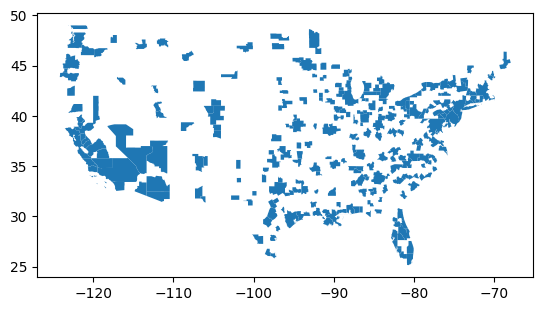

In [6]:
msa_shapes.plot()

## Working with geographic data and pandas data together

Because a geodataframe is still a dataframe in the background, we can do all the same operations as with a Pandas dataframe. Here, we are going to make a common column in the geometry data, and we are going to merge the two to make a geodataframe that includes our variables

In [7]:
msa_shapes['msa'] = msa_shapes['FIPS'].map(int) #Make a column to merge on:
msa_data = msa_shapes.merge(msa_populations) #merged data
msa_data.head() #(We could remove some redundant columns to make it cleaner)

,FIPS,Cnt_FIPS,NAME,AREA_HA,XCOORD,YCOORD,geometry,msa,msa_name,pop1850,...,pop1930,pop1940,pop1950,pop1960,pop1970,pop1980,pop1990,pop2000,pop2010,pop2020
0,0040,1,"Abilene, TX",238072,-99.890106,32.301457,"POLYGON ((-99.63141 32.08128, -99.71397 32.082...",40,"Abilene, TX MSA",0,...,41023,44147,63370,101078,97853,110932,119655,126555,131506,143208
1,0120,2,"Albany, GA",180439,-84.177244,31.661391,"MULTIPOLYGON (((-84.30490 31.69891, -84.29535 ...",120,"Albany, GA MSA",8383,...,30634,36402,50291,81884,96683,112402,112561,120822,122863,118953
2,0160,1,"Albany--Schenectady--Troy, NY",851745,-74.004200,42.802734,"POLYGON ((-73.27429 42.94365, -73.27439 42.942...",160,"Albany-Schenectady-Troy, NY MSA",297882,...,599812,611203,671656,737359,802543,824729,861424,875583,920935,948794
3,0200,2,"Albuquerque, NM",1541394,-106.817543,35.390837,"MULTIPOLYGON (((-106.24795 35.96633, -106.2642...",200,"Albuquerque, NM MSA",12857,...,72760,103534,180592,315485,373805,515614,589131,712738,870694,901483
4,0220,1,"Alexandria, LA",352775,-92.533253,31.198586,"POLYGON ((-92.82365 30.88999, -92.82365 30.899...",220,"Alexandria, LA MSA",11872,...,65455,73370,90648,111351,118078,135282,131556,126337,131613,130023


Now, if we plot msa_data, we can make the color be the population:

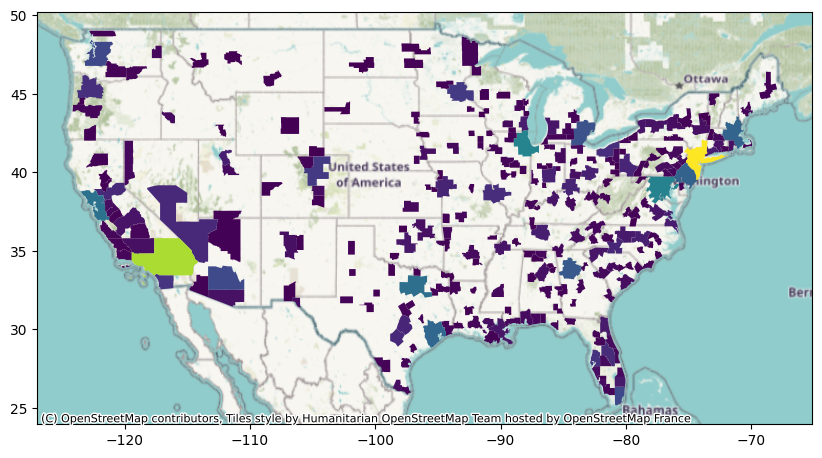

In [8]:
ax = msa_data.plot('pop2020', figsize = (10, 6))
contextily.add_basemap(ax, crs = msa_data.crs) #add a basemap to make it a bit prettier

We can still subset geographic dataframes as if they were dataframes, for instance, we see that they have state codes in the NAME variable, so we can subset MSAs in california:

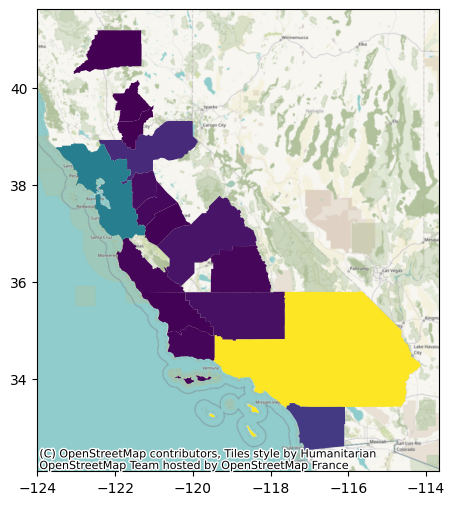

In [9]:
in_cali = [name.endswith(', CA') for name in msa_data.NAME] #remember list comprehensions?
cali_msa_data = msa_data[in_cali]
ax = cali_msa_data.plot('pop2020', figsize = (10, 6))
contextily.add_basemap(ax, crs = cali_msa_data.crs)

However, we can also subset geographically. For instance, we see in the map that the bounding box of California in the coordinate system of the MSA geometry is (-124, 32.5, -114, 42) approximately. We can make another dataframe where we are bounding the msa dataframe by this bounding box:

In [10]:
cali_msa_data_frombounds = msa_data.cx[-124:-114, 32.5:42]

But now, when we plot it, we get MSAs from Nevada because they are in the same box:

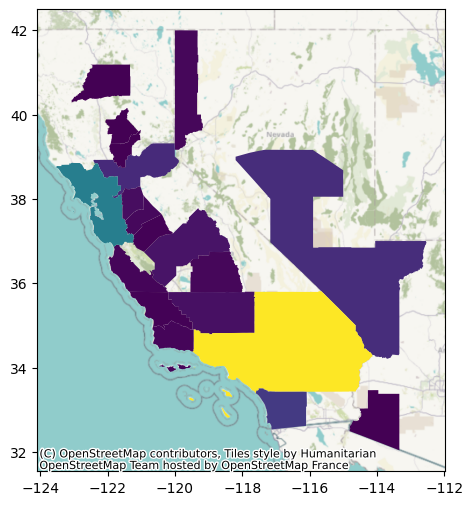

In [11]:
ax = cali_msa_data_frombounds.plot('pop2020', figsize = (10, 6))
contextily.add_basemap(ax, crs = cali_msa_data.crs)

We still compute variables and such:

In [12]:
msa_data['popgr2000_2020'] = ((msa_data['pop2020'] / msa_data['pop2000']) - 1) * 100 #% population growth

And a very quick and dirty plot:

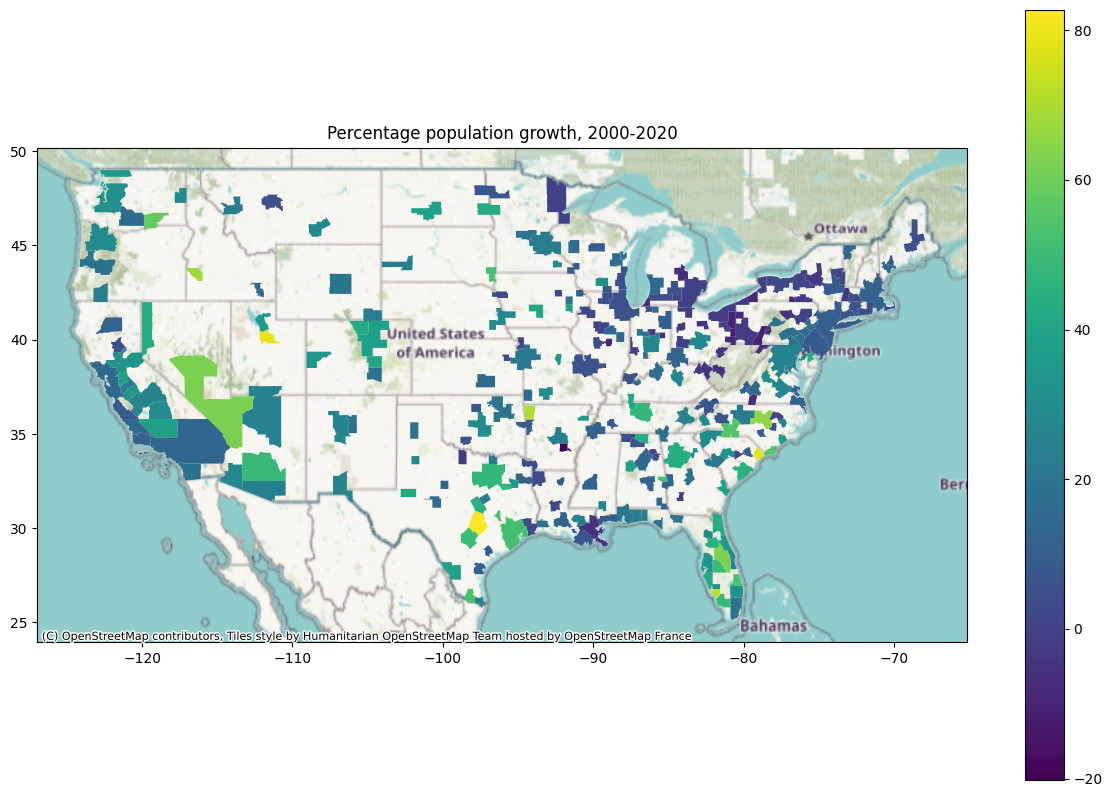

In [13]:
ax = msa_data.plot('popgr2000_2020', figsize=(15, 10), legend = '% population growth')
ax.set_title('Percentage population growth, 2000-2020')
contextily.add_basemap(ax, crs = msa_data.crs)

#### Introduction to working with (Geographic) arrays: Rioxarray + Xarray + Numpy

Much geographic data comes in raster form, that is, a uniform grid of cells where each cell is assigned a value, and the location of each cell in the grid tells us about its location in space or time along regular intervals. 

When it comes to working with array data in Python, it's important to realize that the most cutting-edge or more specialized libraries inherit things from more general ones. In this example we will be using a Rioxarray dataset, which is an extension of an Xarray dataset adding geograhy-based indexes, CRS projections and more, and Xarray in turn is based on Numpy arrays. 

From a practical point of view, this means that Rioxarray datasets 'inherit' the characteristics and the methods associated with Xarray and Numpy arrays, Just like Geopandas inherits all Pandas methods and Pandas Series inherit Numpy methods (And in fact the computation happens inside the Numpy module too)

In [14]:
import os
import pandas as pd, geopandas as gp, numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import shape
from rasterio.windows import from_bounds
from tqdm import tqdm
import xarray, rioxarray

## Downloading a raster dataset for an example

First, we are going to download a raster dataset to play a bit with. You are not expected to understand this code yet, it's an example of things you can do. 

We are taking the dataframe with the "quads" of elevation data provided by the USGS for the whole of the US. Each polygon in this dataframe contains the bounds and the URL for a geotiff raster file with elevation data. We are intersectingt this with the MSA shape of Indianapolis, and we are downloading the four quads that intersect with this MSA and writing them to a raster file. That way, we have an elevation map around the MSA of Indianapolis.

In [15]:
##Read in the files
quads_localfile = ('./data/elevation_quads.geojson')
msa_localfile = ('./data/msa1999_boundaries.shp')
elevation_quads = gp.read_file(quads_localfile)
msa_1999 = gp.read_file(msa_localfile).to_crs(elevation_quads.crs)
#get the bounds of the 1999 msas shapefile, in the crs of the elevation data quads
bounds = msa_1999.to_crs(elevation_quads.crs).dissolve().bounds.values[0]
#Trim elevation quads to the extent of the conterminous USA
elevation_quads = elevation_quads.cx[bounds[0]:bounds[2],bounds[3]:bounds[1]] 
#get rid of quads where there is no elevation tif
non_empty_bool = []
for i in range(len(elevation_quads.index)):
    url = elevation_quads.iloc[i].downloadUrl #Check URL for raster data exists
    non_empty_bool.append(len(url) > 0) #Append to bool list
elevation_quads = elevation_quads[non_empty_bool] #Keep only tiles with raster data
##Get the geodataframe row for Indianapolis:
indy_shape = msa_1999[['Indianapolis' in name for name in msa_1999.NAME]]
#get only the quads that intersect Indianapolis MSA
elevation_quads = elevation_quads.sjoin(msa_1999[['Indianapolis' in name for name in msa_1999.NAME]])
#and the bounds of this
elevation_bounds = elevation_quads.total_bounds
#make a transform object for rasterio to warp the elevation data. Each quad is 3600*3600 pixels
transform_copy = rasterio.transform.from_bounds(
    elevation_bounds[0], 
    elevation_bounds[1], 
    elevation_bounds[2], 
    elevation_bounds[3], 
    3600*2, 
    3600*2
    )
#path to download the elevation tif
download_path = './data/indianapolis_elevation.tif'
#if file does not exist, download it:
if not os.path.isfile(download_path):
    #read one quad to get the dtype for the new rasterio dataset
    with rasterio.open(elevation_quads.iloc[3].downloadUrl) as sample_raster:# open with rasterio the cloud-stored data using the download url
        sample_array = sample_raster.read()[0,:,:]
    #initalize raster dataset to write to
    with rasterio.open(download_path, 
        'w', 
        driver = "GTiff", 
        dtype = sample_array.dtype, 
        height = 3600*2,
        width = 3600*2,
        nodata = 0, 
        count = 1,
        crs = elevation_quads.crs,
        transform = transform_copy,
        compress = 'DEFLATE',
        tiled=True, 
        blockxsize=256, 
        blockysize=256, 
        BIGTIFF='YES'
        ) as big_elevation_raster:
        pass
    #download data from each quad and write it to the raster
    with rasterio.open(download_path, 'r+') as big_elevation_raster:
        print("Downloading elevation model to big geotiff")
        counter = tqdm(total=len(elevation_quads.index), desc = "Progress")
        for i in range(len(elevation_quads.index)):
            url = elevation_quads.iloc[i].downloadUrl  #Get URL of geotiff
            with rasterio.open(url) as rasterio_to_write: #Open geotiff
                bounds_to_write = elevation_quads.iloc[i].geometry.bounds
                #get bounds of geotiff to write
                rows, cols = rasterio.transform.rowcol(transform_copy, (bounds_to_write[0], bounds_to_write[2]), (bounds_to_write[3], bounds_to_write[1])) 
                #Get the columns and rows in big_elevation_raster from its transform and the bounds of the elevation geotiff
                data_to_write = rasterio_to_write.read(window = Window.from_slices(slice(6, 3606), slice(6, 3606))) #read the data itself
                writewindow = Window.from_slices(rows, cols)
                big_elevation_raster.write(data_to_write, window = writewindow)
            counter.update()
        counter.refresh()
        factors = [8,16,64]
        big_elevation_raster.build_overviews(factors, Resampling.nearest)
        big_elevation_raster.update_tags(ns='rio_overview', resampling='nearest')


In [16]:
msa_localfile = ('./data/msa1999_boundaries.shp')
indianapolis_elevation_file = './data/indianapolis_elevation.tif'

Now, we can open the same raster file (it's a .tif, like a photo) using several packages

In [17]:
msa_shapes = gp.read_file(msa_localfile)
indy_elevation = rasterio.open(indianapolis_elevation_file)
indy_elevation_rio = rioxarray.open_rasterio(indy_elevation).sel(band = 1)
indy_elevation_xarray = xarray.DataArray(data = indy_elevation_rio.data, dims = ['x', 'y'], coords = (list(range(0, 7200*30, 30)), list(reversed(range(0, 7200*30, 30)))))
# indy_elevation_rio = indy_elevation_rio[1200:2400, 1200:2400]

If we use rioxarray, it opens it as fancy numpy array:

In [18]:
indy_elevation_rio

<xarray.DataArray (y: 7200, x: 7200)> Size: 207MB
array([[207.57849, 207.51236, 207.4924 , ..., 248.5301 , 248.60011, 248.63893],
       [207.67952, 207.5192 , 207.44365, ..., 248.64462, 248.68864, 248.70728],
       [207.91185, 207.72755, 207.60974, ..., 248.82074, 248.7907 , 248.78374],
       ...,
       [149.76297, 149.55061, 149.5245 , ..., 182.96803, 176.5112 , 170.92838],
       [149.21999, 149.50389, 149.51604, ..., 177.49829, 172.43712, 167.94344],
       [149.36816, 149.16765, 149.56227, ..., 172.4757 , 167.78792, 164.46272]],
      dtype=float32)
Coordinates:
    band         int32 4B 1
  * x            (x) float64 58kB -87.0 -87.0 -87.0 -87.0 ... -85.0 -85.0 -85.0
  * y            (y) float64 58kB 41.0 41.0 41.0 41.0 ... 39.0 39.0 39.0 39.0
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

If we use the .data attribute, we see that it's an array in the background:

In [19]:
indy_elevation_rio.data

array([[207.57849, 207.51236, 207.4924 , ..., 248.5301 , 248.60011,
        248.63893],
       [207.67952, 207.5192 , 207.44365, ..., 248.64462, 248.68864,
        248.70728],
       [207.91185, 207.72755, 207.60974, ..., 248.82074, 248.7907 ,
        248.78374],
       ...,
       [149.76297, 149.55061, 149.5245 , ..., 182.96803, 176.5112 ,
        170.92838],
       [149.21999, 149.50389, 149.51604, ..., 177.49829, 172.43712,
        167.94344],
       [149.36816, 149.16765, 149.56227, ..., 172.4757 , 167.78792,
        164.46272]], dtype=float32)

But it has many other attributes and properties that a numpy array does not have, for instance, you cannot do this with a numpy array:

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

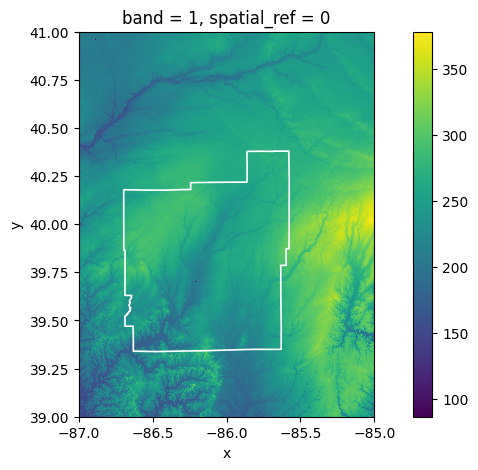

In [61]:
from matplotlib import pyplot as plt
f, ax = plt.subplots(1, figsize = (10, 5))
indy_elevation_rio.plot(ax = ax)
#and we plot the bounds of the city on top
indy_shape.plot(ax = ax, facecolor="none", 
              edgecolor='white', lw = 1.2)

Because it has geographic properties, you can for instance make a new dataset by clipping it to a geometry:

In [70]:
indy_elevation_rio_clipped = indy_elevation_rio.rio.clip_box(*indy_shape.bounds.iloc[0]) #use rio.cip_box method, inputting the unpacked tuple of geometry bounds

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

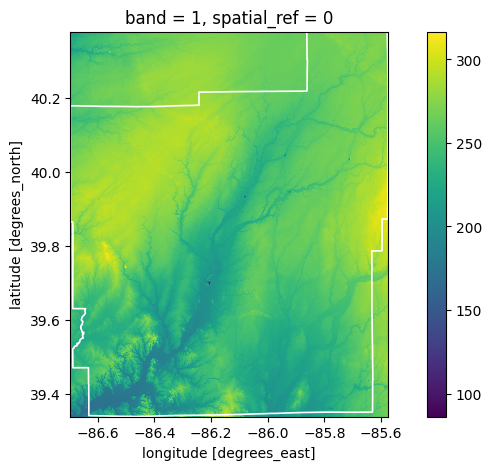

In [69]:
from matplotlib import pyplot as plt
f, ax = plt.subplots(1, figsize = (10, 5))
indy_elevation_rio_clipped.plot(ax = ax)
#and we plot the bounds of the city on top
indy_shape.plot(ax = ax, facecolor="none", 
              edgecolor='white', lw = 1.2)

You can use Numpy methods on these rioxarrays, in this case we make a boolean array where altitude is higher than 250 meters:

In [21]:
indy_elevation_rio_high = indy_elevation_rio.copy()
indy_elevation_rio_high.data = np.greater(indy_elevation_xarray, 250)
indy_elevation_rio_high

<xarray.DataArray (y: 7200, x: 7200)> Size: 52MB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    band         int32 4B 1
  * x            (x) float64 58kB -87.0 -87.0 -87.0 -87.0 ... -85.0 -85.0 -85.0
  * y            (y) float64 58kB 41.0 41.0 41.0 41.0 ... 39.0 39.0 39.0 39.0
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

In [22]:
np.mean(indy_elevation_rio_high)

<xarray.DataArray ()> Size: 8B
array(0.52658781)
Coordinates:
    band         int32 4B 1
    spatial_ref  int32 4B 0

But now, if we plot this, it's a boolean, where ones are places higher than 200 meters:

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

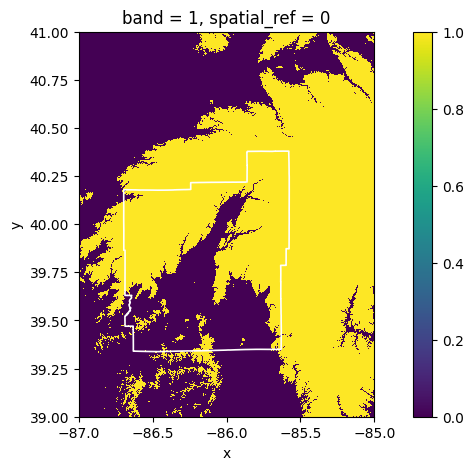

In [24]:
f, ax = plt.subplots(1, figsize = (10, 5))
indy_elevation_rio_high.plot(ax = ax)
#and we plot the bounds of the city on top
indy_shape.plot(ax = ax, facecolor="none", 
              edgecolor='white', lw = 1.2)

You can use the `np.asarray()` method to "extract" the underlying array data out of the `rioxarray` data array, however, it becomes stripped of all the additional attributes and methods provided by `rioxarray`

In [25]:
indy_elevation_rio_array = np.asarray(indy_elevation_xarray)
indy_elevation_rio_array

array([[207.57849, 207.51236, 207.4924 , ..., 248.5301 , 248.60011,
        248.63893],
       [207.67952, 207.5192 , 207.44365, ..., 248.64462, 248.68864,
        248.70728],
       [207.91185, 207.72755, 207.60974, ..., 248.82074, 248.7907 ,
        248.78374],
       ...,
       [149.76297, 149.55061, 149.5245 , ..., 182.96803, 176.5112 ,
        170.92838],
       [149.21999, 149.50389, 149.51604, ..., 177.49829, 172.43712,
        167.94344],
       [149.36816, 149.16765, 149.56227, ..., 172.4757 , 167.78792,
        164.46272]], dtype=float32)

Numpy arrays do not have an own method for plotting: 

```python
indy_elevation_rio_array.plot()


---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
h:\My Drive\CEMFI\2022_PhD\gds4ae_practice_2023\session1.ipynb Cell 147 in <cell line: 1>()
----> 1 indy_elevation_rio_array.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'
```

#### Calculations on rasters: Use methods implemented by others!!!!
Here we have a weakness of Python: loops are really, really, really slow. Python is a slow language in general. People use Python for data science and GIS because the packages that we have been looking at so far do not actually run on Python itself, they are libraries which tie to programs written in compiled languages like C. This means that when you use the methods provided in packages like Numpy, Pandas, Xarray, etc. they are actually calling compiled, optimized libraries, and they are much, much, much faster than anything you can write yourself in Python. 

##### A function to calculate slope of a raster written in pure Python: 

This is a function to calculate slope in degrees from a DEM, using the algorithm that is present in ArcGIS

In [26]:
import numpy as np
from tqdm.contrib.itertools import product as tqdmproduct
from itertools import product
from numpy import sqrt
ngjit = jit(nopython = True, nogil = True)
def point_slope(arr, i, j): ##Given array, indexes i and j, calculate the slope from the formula in ArcGis
    ##Note that it fails on the edges of the array!
    temprows = (max(i-1,0), min(i+2, np.shape(arr)[1]))
    tempcols = (max(j-1,0), min(j+2, np.shape(arr)[1]))
    temp = arr[temprows[0]:temprows[1], tempcols[0]:tempcols[1]]    
    dz_dx = ((temp[0,2]+temp[2,2]+2.0*temp[1,2])-(temp[0,0]+temp[2,0]+2.0*temp[2,1]))/240.0
    dy_dx = ((temp[2,0]+temp[2,2]+2.0*temp[2,1])-(temp[0,0]+temp[0,2]+2.0*temp[1,2]))/240.0
    deg = np.arctan(sqrt(np.square(dz_dx) + np.square(dy_dx)))*57.29578
    return deg

def calc_slope(arr): ##Loop over elements of the array calculating the slope
    rug = np.zeros((np.shape(arr)[0], np.shape(arr)[1]), dtype = np.float32)
    rug[:] = np.nan
    for i, j in tqdmproduct(range(1,(np.shape(arr)[0]-1)), range(1,(np.shape(arr)[1]-1))):
        rug[i,j] = point_slope(arr, i, j)
    return rug

def outer_calc_slope(arr, name: str = 'slope'): ##For use with xarrays: extract the data first (Huge optimization)
    out = calc_slope(arr.data)
    return xarray.DataArray(out,
                        name=name,
                        coords=arr.coords,
                        dims=arr.dims,
                        attrs=arr.attrs)

And this is the same code, but compiled using Numba

In [44]:
@ngjit
def point_slope_jit(arr, i, j):
    temprows = (max(i-1,0), min(i+2, np.shape(arr)[1]))
    tempcols = (max(j-1,0), min(j+2, np.shape(arr)[1]))
    temp = arr[temprows[0]:temprows[1], tempcols[0]:tempcols[1]]    
    dz_dx = ((temp[0,2]+temp[2,2]+2.0*temp[1,2])-(temp[0,0]+temp[2,0]+2.0*temp[2,1]))/240.0
    dy_dx = ((temp[2,0]+temp[2,2]+2.0*temp[2,1])-(temp[0,0]+temp[0,2]+2.0*temp[1,2]))/240.0
    deg = np.arctan(sqrt(np.square(dz_dx) + np.square(dy_dx)))*57.29578
    return deg

@ngjit
def calc_slope_jit(arr): 
    rug = np.zeros((np.shape(arr)[0], np.shape(arr)[1]), dtype = np.float32)
    rug[:] = np.nan 
    # for ij, data in np.ndenumerate(arr):
    #     rug[ij] = point_slope_jit(arr, ij[0], ij[1])
    for i in range(1,(np.shape(arr)[0]-1)):
        for j in range(1,(np.shape(arr)[1]-1)):
            rug_p = point_slope_jit(arr, i, j)
            if rug_p <= 1: rug[i,j] = rug_p
            else: rug[i,j] = 1.0 #small check because I'm not using the correct coordinate system
    return rug

def calc_slope_outer(arr,
          name: str = 'slope'):
    out = calc_slope_jit(arr.data)
    return xarray.DataArray(out,
                        name=name,
                        coords=arr.coords,
                        dims=arr.dims,
                        attrs=arr.attrs)

In [35]:
import time

You can use the Python code on a Rioxarray, but it takes forever, same as a numpy array:

In [36]:
bef = time.time()
slope_loop = calc_slope(indy_elevation_xarray[100:200, 100:200])
aft = time.time()
print(f"Calculating slope using loop on xarray.DataArray took {aft-bef:5f} seconds")

  0%|          | 0/9604 [00:00<?, ?it/s]

Calculating slope using loop on xarray.DataArray took 43.054666 seconds


However, it is very fast when compiled:

In [43]:
comp = calc_slope_outer(indy_elevation_xarray[100:120, 100:120]) ##Run one time for it to compile
bef = time.time()
slope_jit = calc_slope_outer(indy_elevation_xarray)
aft = time.time()
print(f"Calculating slope using JIT-compiled function on numpy array took {aft-bef:5f} seconds")

Calculating slope using JIT-compiled function on numpy array took 1.142811 seconds


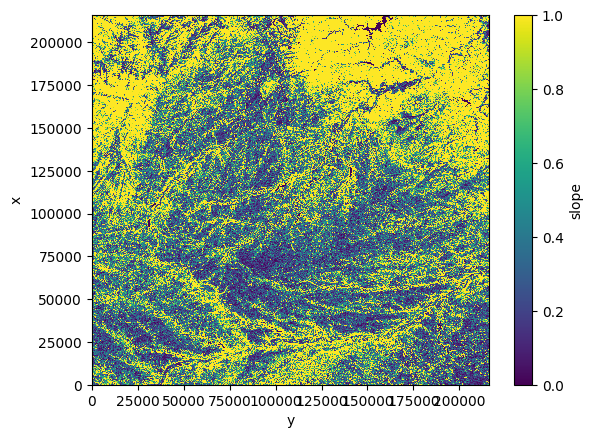

In [45]:
slope_jit.plot(cmap = 'viridis')

Now, we know the altitude and the terrain slope around Indianapolis. We can use what we learned about vectorized operations to check places which are high AND slopey.

In [59]:
high_and_slopey = indy_elevation_rio.copy()
high_and_slopey.data = (indy_elevation_rio.data > 250) & (slope_jit.data > 0.5)


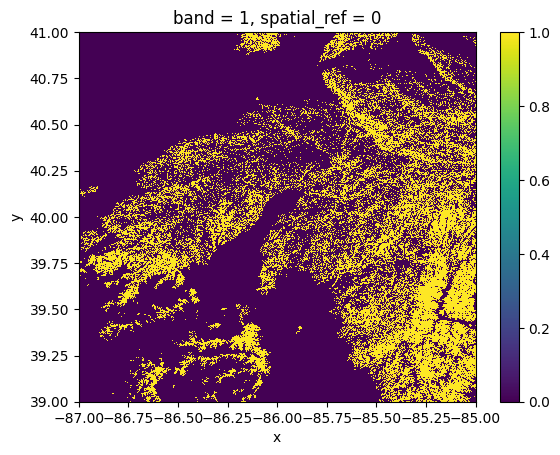

In [60]:
high_and_slopey.plot()

In [ ]:
indy_elevation_rio.rio.clip_box